In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime

In [6]:
#road class conversion of CYCLANDS 1st_Road_Class variable
road_classes = np.array(['','M','A(M)','A','B','C','U'])

##upper left, lower right corners of Greater London (lat,long)

#Dan's
# corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

#Greg's
corners = [(51.543,-0.179),(51.475,0.023)]

In [7]:
#collision data from CYCLANDS
collisions = pd.read_csv('./uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values

#annual average daily flow traffic data from https://roadtraffic.dft.gov.uk
aadf = pd.read_csv('./uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [32]:
#def geomatch(collision,aadf,corners=[(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]):
    

collision = collisions.iloc[100]
    
year = collision.Date.year

aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
neigh.fit(aadf_year[['Longitude','Latitude']].values)
A,B = neigh.kneighbors(collision[['Longitude','Latitude']].values.reshape(1,-1),1)

aadf.isin(aadf_year.iloc[B[0][0]])

if aadf_year.iloc[B[0][0]].Road_name == collision.Road_name:
    print(aadf.index[(aadf.Count_point_id == aadf_year.iloc[B[0][0]].Count_point_id) & (aadf.Year == aadf_year.iloc[B[0][0]].Year)])
else:
    print('no_match')
    
    

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.

In [8]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],1)
    
    #count correct geomatches
    matches += np.sum(aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values)
    
    A_match = A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]
    
    print(year)
    print('mean distance to CP:',A_match.mean()*61.8)
    print('median distance to CP:',np.median(A_match)*61.8)
    print('max distance to CP:',A_match.max()*61.8)
    print('min distance to CP:',A_match.min()*61.8)
    print('Correct geo match:',len(A_match))
    print('Total London collisions:',len(collisions_year))
    print()

print('Correct geo match:',matches)
print('Total London collisions:',london_col)

2005
mean distance to CP: 0.08699429734488669
median distance to CP: 0.06424967946999885
max distance to CP: 0.420734100424044
min distance to CP: 0.0025005235440245023
Correct geo match: 432
Total London collisions: 978

2006
mean distance to CP: 0.0881463543394167
median distance to CP: 0.06481826636910165
max distance to CP: 0.4645666445738254
min distance to CP: 0.0025709668155781402
Correct geo match: 485
Total London collisions: 1088

2007
mean distance to CP: 0.09389976904542398
median distance to CP: 0.06662460680203983
max distance to CP: 0.41958768113371936
min distance to CP: 0.002571929174308482
Correct geo match: 512
Total London collisions: 1099

2008
mean distance to CP: 0.08367684006135685
median distance to CP: 0.06354755202524263
max distance to CP: 0.5276425133499693
min distance to CP: 0.002573319643253185
Correct geo match: 562
Total London collisions: 1224

2009
mean distance to CP: 0.09196774443927501
median distance to CP: 0.06908568663186225
max distance to CP:

Text(0.5, 1.0, '2018')

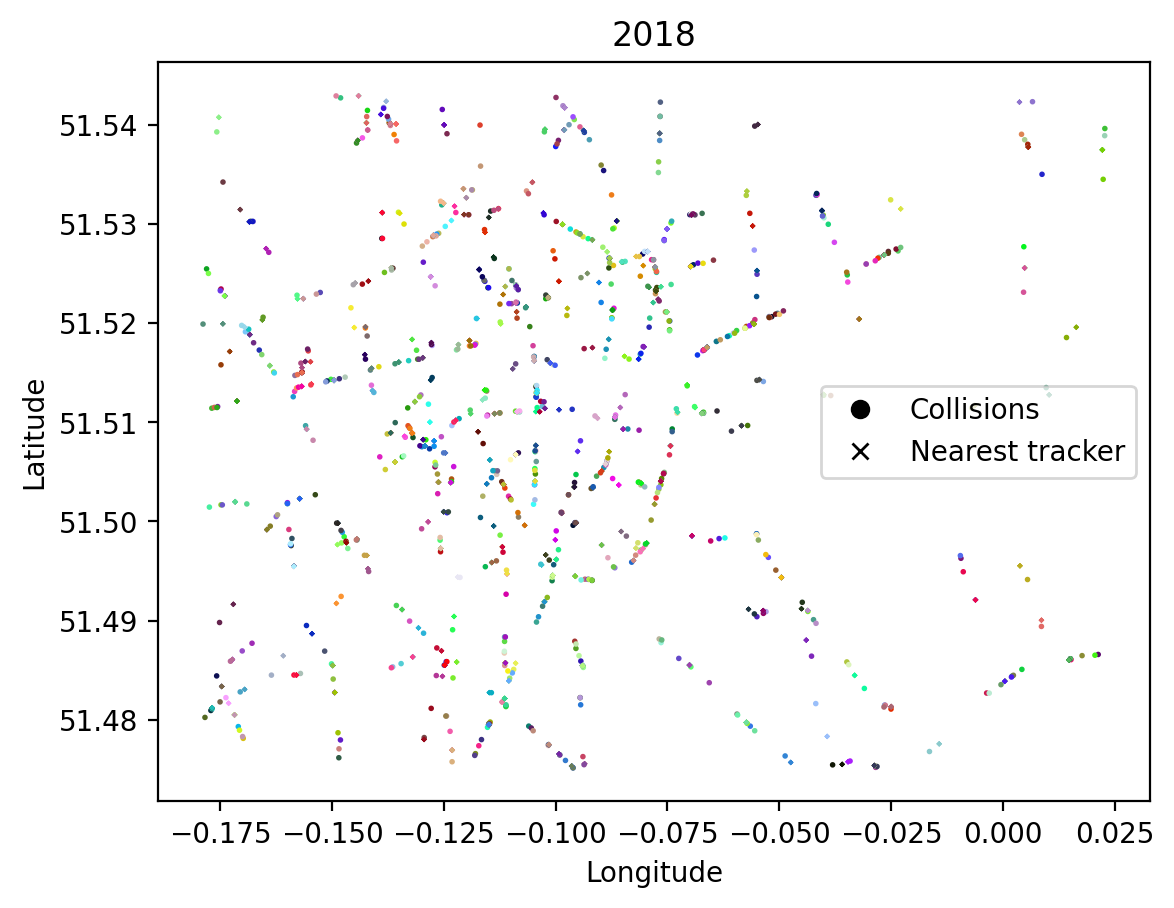

In [9]:
plotN = 700

colors = np.random.rand(plotN,3)

match_mask = aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match_mask].head(plotN).Longitude,collisions_year.iloc[match_mask].head(plotN).Latitude,c=colors,s=1)
# for i,(txt,long,lat) in enumerate(zip(collisions_year.iloc[match_mask].head(plotN).Road_name.values,collisions_year.iloc[match_mask].head(plotN).Longitude.values,collisions_year.iloc[match_mask].head(plotN).Latitude.values)):
#     ax.annotate(txt, (long,lat),color='black')


ax.scatter(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values,c=colors,marker='x',s=1)
# for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values)):
#     ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.title('2018')

## Examine nearest neighbors

In [10]:
year = 2018

aadf2018 = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
collisions2018 = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()

In [11]:
from sklearn.neighbors import NearestNeighbors

In [12]:
neigh = NearestNeighbors(n_neighbors=1,radius=0.1)

In [13]:
neigh.fit(aadf2018[['Longitude','Latitude']])

NearestNeighbors(n_neighbors=1, radius=0.1)

In [14]:
A,B = neigh.kneighbors(collisions2018[['Longitude','Latitude']],10)

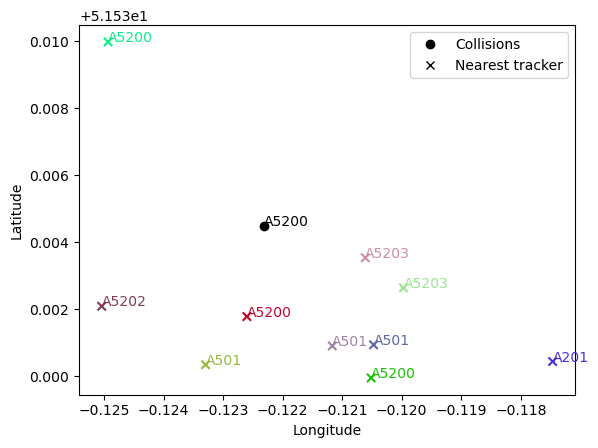

In [15]:
plotN = 50

colors = np.random.rand(10,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude,c='black')
ax.annotate(road_classes[collisions2018.iloc[plotN]['1st_Road_Class']]+str(collisions2018.iloc[plotN]['1st_Road_Number']), (collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude),color='black')

ax.scatter(aadf2018.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf2018.iloc[B[plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf2018.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf2018.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf2018.iloc[B[plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [49]:
aadf2018.iloc[B[plotN].flatten().tolist()].Road_name.values

array(['A200', 'A101', 'A2206', 'A2208', 'A2208', 'A2208', 'A2208', 'C',
       'A200', 'A200', 'U', 'A2208', 'A1203', 'A101', 'A200', 'U', 'A200',
       'A200', 'B207', 'A13'], dtype=object)

In [55]:
aadf2018.iloc[B[plotN].flatten().tolist()].Start_junction_road_name.values

array(['A101', 'A200', 'A100/A2205', 'A2206', 'Rotherhithe New Rd',
       'Hawkstone Rd', 'A2', nan, 'A2208', 'A2208', nan, 'A200', 'A1202',
       'LA Boundary', 'A2208', nan, 'A2208', 'B202', nan,
       'A11/A1202 mid-junction'], dtype=object)

In [174]:
aadf_year.iloc[B.flatten().tolist()].Road_name.values

array(['A4206', 'A4000', 'U', ..., 'A780', 'A701', 'A75'], dtype=object)

In [173]:
collisions_year.Road_name.values

16852

In [183]:
A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]

array([[0.00530392],
       [0.00040256],
       [0.00213593],
       ...,
       [0.0206665 ],
       [0.00153796],
       [0.00337566]])

In [195]:
len(collisions)

250963

In [239]:
collisions.iloc[0].Date.year

2005

In [34]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],10)
    
#     #count correct geomatches

    match_idx = np.zeros((len(B),10))
    
    for i in range(10):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
    
    # aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values
    
#     matches += np.sum(aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values)
    
#     A_match = A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]
    
    # print(year)
    # print('mean distance to CP:',A_match.mean()*61.8)
    # print('median distance to CP:',np.median(A_match)*61.8)
    # print('max distance to CP:',A_match.max()*61.8)
    # print('min distance to CP:',A_match.min()*61.8)
    # print('Correct geo match:',len(A_match))
    # print('Total London collisions:',len(collisions_year))
    # print()

print('Correct geo match:',matches)
print('Total London collisions:',london_col)

Correct geo match: 0
Total London collisions: 20718


In [79]:
invalid_val = np.nan
mask = match_idx != 0
check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)

In [80]:
for i in range(30):
    print(check[i],match_idx[i])

0.0 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
2.0 [0. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
0.0 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
3.0 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
1.0 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 [0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
1.0 [0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
0.0 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nan [0. 0. 0. 0. 0. 0. 0. 0.

In [85]:
np.nansum(check)

818.0

In [30]:
for i in range(10):
    print(len(B[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i]))
    
    

710
383
286
233
231
213
173
155
146
151


In [20]:
 aadf_year.iloc[B[2].flatten().tolist()].Road_name.values

array(['A2', 'A2', 'A2', 'A2', 'U', 'B207', 'A2209', 'A200', 'A200',
       'A2209'], dtype=object)